In [25]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv('Final_2_Dec.csv',index_col=0).drop('YEAR',axis=1)

In [3]:
df.head()

,DEP_TIME,WIND_SPEED,RAIN,SNOW,SNOW_DEPTH,TAVG,FOG,HEAVY_FOG,THUNDER,HAIL,...,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,8.0,7.83,0.0,0.0,0.0,72,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,8.0,7.83,0.0,0.0,0.0,72,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,6.0,7.83,0.0,0.0,0.0,72,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,18.0,7.83,0.0,0.0,0.0,72,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,8.0,7.83,0.0,0.0,0.0,72,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [4]:
random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(df.drop('Y',axis=1), df.Y, test_size=0.25)

In [5]:
dt = DecisionTreeClassifier(criterion='entropy')
kfolds = KFold(n_splits = 5)
param_grid_dt = {'min_samples_leaf':[2,5,10,20,50,75,100], 'min_samples_split':[2,5,10,20,50,75,100]}
dt_grid_search = GridSearchCV(dt, param_grid_dt, cv = kfolds, scoring = 'roc_auc') 
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 5, 10, 20, 50, 75, 100], 'min_samples_leaf': [2, 5, 10, 20, 50, 75, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [7]:
dt_grid_search.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=75,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [8]:
from sklearn.metrics import roc_curve, auc
predictions = dt_grid_search.predict(X_test)

In [9]:
dt_grid_search.score(X_test,y_test)

0.7594428956001491

In [10]:
def plotAUC(truth, pred, lab):
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color=c, label= lab+' (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")

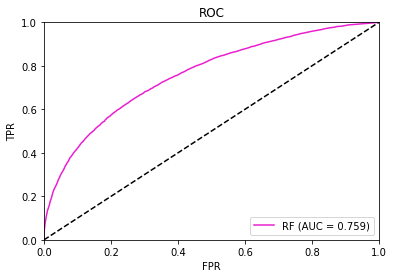

In [11]:
plotAUC(y_test, dt_grid_search.predict_proba(X_test)[:,1], 'RF')

<h1>Baseline accuracy</h1>

In [60]:
preds = [0 for i in range(len(X_train))]
from sklearn.metrics import accuracy_score
accuracy_score(y_train, preds)

0.8023111052248195

<h1> Confusion Matrix </h1>

In [62]:
from sklearn.metrics import confusion_matrix,classification_report

y_pred = dt_grid_search.predict(X_test)
target_names = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_names))

print(confusion_matrix(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.84      0.97      0.90     40442
          1       0.66      0.22      0.33      9895

avg / total       0.80      0.82      0.79     50337

[[39365  1077]
 [ 7765  2130]]


In [64]:
7765.0/(7765+39365)

0.1647570549543815

In [68]:
df.columns

Index([u'DEP_TIME', u'WIND_SPEED', u'RAIN', u'SNOW', u'SNOW_DEPTH', u'TAVG',
       u'FOG', u'HEAVY_FOG', u'THUNDER', u'HAIL', u'GLAZE', u'HAZE',
       u'BLOWING_SNOW', u'Y', u'HOLIDAY', u'9E', u'AA', u'AS', u'B6', u'DL',
       u'HA', u'MQ', u'OH', u'OO', u'VX', u'YX', u'JAN', u'FEB', u'MAR',
       u'APR', u'MAY', u'JUN', u'JUL', u'AUG', u'SEP', u'OCT', u'NOV', u'DEC'],
      dtype='object')

<h1>Bootstrap</h1>

In [30]:
def modBootstrapper(train, test, nruns, sampsize):
    aucs=[]
    for loop in range(nruns):
        train_data = train.sample(sampsize,replace=True)
        dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50, min_samples_split=75).fit(train_data.drop('Y',axis=1),train_data.Y)
        scores = dt.predict_proba(test.drop('Y',1))[:,1]
        auc_value = roc_auc_score(test.Y,scores)
        aucs.append(auc_value)
    mean_val = np.mean(aucs)
    stderr = np.sqrt(np.var(aucs))
    return (mean_val,stderr)

In [31]:
df = pd.read_csv('Final_2_Dec.csv',index_col=0).drop('YEAR',axis=1)
random.seed(0)
df_train, df_test = train_test_split(df,test_size=0.25)

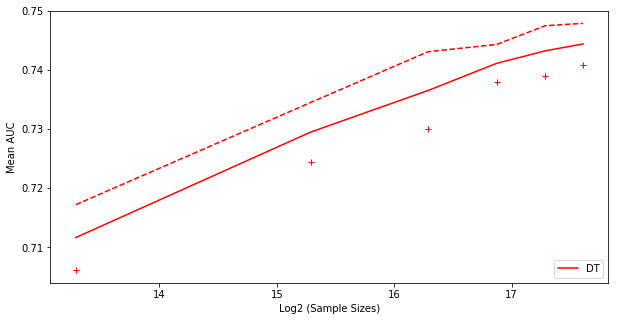

In [32]:
sample_sizes = [10000,40000,80000,120000,160000,200000]
dt_auc = []

nruns=10
for sampsize in sample_sizes:
    dt_auc.append(modBootstrapper(df_train,df_test,nruns,sampsize))
    
dt_means,dt_stderr = [i[0] for i in dt_auc], [i[1] for i in dt_auc]

plt.figure(figsize=(10,5))
plt.plot(np.log2(sample_sizes),dt_means,'r',label="DT")
plt.plot(np.log2(sample_sizes),np.add(dt_means,np.multiply(-2,dt_stderr)),'+r')
plt.plot(np.log2(sample_sizes),np.add(dt_means,np.multiply(2,dt_stderr)),'--r')
#plt.xticks(np.log2(sample_sizes))
plt.legend(loc=4)
plt.xlabel('Log2 (Sample Sizes)')
plt.ylabel('Mean AUC')
plt.show()

In [12]:
df.shape

(201347, 38)